# 4.1. Modelo: Clasificador BERT

Se busca predecir la rama del arbol de categorias(familia, categoria y sub-categoria) en la que se encuentra un producto dado.

### Enlaces

- [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](http://jalammar.github.io/illustrated-bert/)
- [Text Classification with BERT in PyTorch](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)
- [Tutorial: Fine tuning BERT for Sentiment Analysis](https://skimai.com/fine-tuning-bert-for-sentiment-analysis/)
- [BERT models](https://huggingface.co/models)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy  as np
import pandas as pd

import torch
import transformers
from   torch import nn
from   torch.optim import Adam
    
import logging

from data.fashion import load_datasets
import data  as dt
import model as ml

import util  as ut
import pytorch_common.util as pu

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.12.1+cu116'

In [6]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-11-14 23:10:44,681 - INFO - cuda:0


In [7]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

## Funciones Helper

In [8]:
label_by_class = lambda df: {row['branch_seq']: row['branch'] for _, row in df[['branch_seq', 'branch']].drop_duplicates().iterrows() }

## Parametros

Fijamos la semilla para todas las librerias:

In [9]:
ut.set_seed(42)

Definimos el modelo preentrenado a utilizar. Este es una capa/module mas de nuestro modelo.

In [10]:
MODEL_NAME ='bert-base-cased'
# MODEL_NAME ='bert-base-uncased'
# MODEL_NAME = 'bert-large-uncased'
# MODEL_NAME ='distilbert-base-uncased'

Definimos los paths del dataset y pesos del modelo:

In [11]:
DATASET_PATH       = '../../datasets/fashion-outfits'
IMAGES_PATH        = '../../datasets/fashion-outfits/images'
WEIGHTS_PATH       = '../../weights'
CACHE_PATH         = '../../cache'
MODEL_WEIGHTS_PATH = f'{WEIGHTS_PATH}/{MODEL_NAME}.h5'

In [12]:
TRAIN = True

In [13]:
!mkdir -p {WEIGHTS_PATH}

## Cargar dataset

In [14]:
train_set, val_set, test_set = load_datasets(DATASET_PATH, prefix='bert_')

In [15]:
train_set['tokens_count'] = train_set['features'].apply(lambda x: len(x.split(' ')))
val_set['tokens_count']   = val_set['features'].apply(lambda x: len(x.split(' ')))
test_set['tokens_count']  = test_set['features'].apply(lambda x: len(x.split(' ')))

In [16]:
max_tokens_count = max([train_set['tokens_count'].max(), val_set['tokens_count'].max(), test_set['tokens_count'].max()])
max_tokens_count

35

Tamaño máximo de la secuencia de entrada:

In [17]:
tokens_count = 2 + max_tokens_count
tokens_count

37

Definimos el tokenizer y los dataset para tran, validation y test:

In [18]:
tokenizer = ml.Tokenizer(
    tokenizer  = transformers.BertTokenizer.from_pretrained(MODEL_NAME), 
    padding    = 'max_length',
    max_length = tokens_count
)

In [19]:
train_dataset = dt.Dataset(train_set, feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)
val_dataset   = dt.Dataset(val_set,   feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)
test_dataset  = dt.Dataset(test_set,  feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)

## Preparando el modelo

Cantidad de clases a predecir:

In [20]:
len(train_set['branch_seq'].unique())

194

In [21]:
n_classes = train_set['branch_seq'].max() + 1
n_classes

194

In [22]:
classifier = ml.Classifier(
    transformer     = transformers.BertModel.from_pretrained(
        MODEL_NAME, 
        use_cache = True, 
        cache_dir = CACHE_PATH
    ),
    output_dim      = n_classes,
    dropout         = 0,
    hiden_state_dim = 768
)

## Entrenamiento

In [23]:
if TRAIN:
    model = ml.ModelTrainer(classifier, batch_size = 40, criterion = nn.CrossEntropyLoss())

In [24]:
if TRAIN:
    LR     = 0.00001
    EPOCHS = 8

    model.fit(
        train_dataset, 
        val_dataset = val_dataset,
        optimizer   = Adam(classifier.parameters(), lr = LR),
        epochs      = EPOCHS
    )

2022-11-14 23:15:14,784 - INFO - Time: 0:03:32.43 | Epoch: 1 | Train(loss: 0.064499, acc: 51.87%) | Val(loss: 0.032272, acc: 70.88%) | acc diff: 19.01%
2022-11-14 23:18:50,918 - INFO - Time: 0:03:36.13 | Epoch: 2 | Train(loss: 0.028944, acc: 73.12%) | Val(loss: 0.024460, acc: 75.08%) | acc diff: 1.96%
2022-11-14 23:22:26,720 - INFO - Time: 0:03:35.80 | Epoch: 3 | Train(loss: 0.023321, acc: 76.22%) | Val(loss: 0.021971, acc: 76.57%) | acc diff: 0.35%
2022-11-14 23:26:00,887 - INFO - Time: 0:03:34.17 | Epoch: 4 | Train(loss: 0.020843, acc: 77.88%) | Val(loss: 0.021008, acc: 77.24%) | acc diff: 0.64%
2022-11-14 23:29:32,773 - INFO - Time: 0:03:31.89 | Epoch: 5 | Train(loss: 0.019199, acc: 78.98%) | Val(loss: 0.020425, acc: 77.79%) | acc diff: 1.19%
2022-11-14 23:33:05,261 - INFO - Time: 0:03:32.49 | Epoch: 6 | Train(loss: 0.017808, acc: 80.29%) | Val(loss: 0.020380, acc: 77.66%) | acc diff: 2.63%
2022-11-14 23:36:37,431 - INFO - Time: 0:03:32.17 | Epoch: 7 | Train(loss: 0.016484, acc: 81.

In [25]:
if TRAIN:
    classifier.save(MODEL_WEIGHTS_PATH)

## Evaluación

In [26]:
classifier.load(MODEL_WEIGHTS_PATH)

In [27]:
model   = ml.ModelTrainer(classifier, batch_size = 40, criterion = nn.CrossEntropyLoss())
summary = model.validate(test_dataset)
summary.show()

Accuracy: 81.28%, Loss: 0.017364


Guardamos target y predicciones:

In [28]:
label_by_class_dict = label_by_class(test_set)

pd.DataFrame({
    'prediction': [label_by_class_dict[e] for e in np.concatenate(summary.predictions)],
    'target'     : [label_by_class_dict[e] for e in np.concatenate(summary.targets)]
}).to_csv(f'{DATASET_PATH}/bert-pred-target.csv', index=False)

In [29]:
np.array(summary.targets).shape

(2848,)

                                                               precision    recall  f1-score   support

                                        accessories~belts~n/d       0.96      0.96      0.96       146
                             accessories~hair accessories~n/d       0.83      0.87      0.85        39
                                         accessories~hats~n/d       0.97      0.99      0.98       254
                    accessories~phone, computer & gadgets~n/d       0.65      0.82      0.73        39
                                      accessories~scarves~n/d       0.99      0.98      0.99      2000
                                   accessories~sunglasses~n/d       1.00      0.99      0.99       186
                              accessories~ties & bow ties~n/d       0.90      0.95      0.93        20
                        accessories~wallets & cardholders~n/d       0.80      0.75      0.77        32
                             accessories~wallets & purses~n/d       0.60

<Figure size 4500x4500 with 2 Axes>

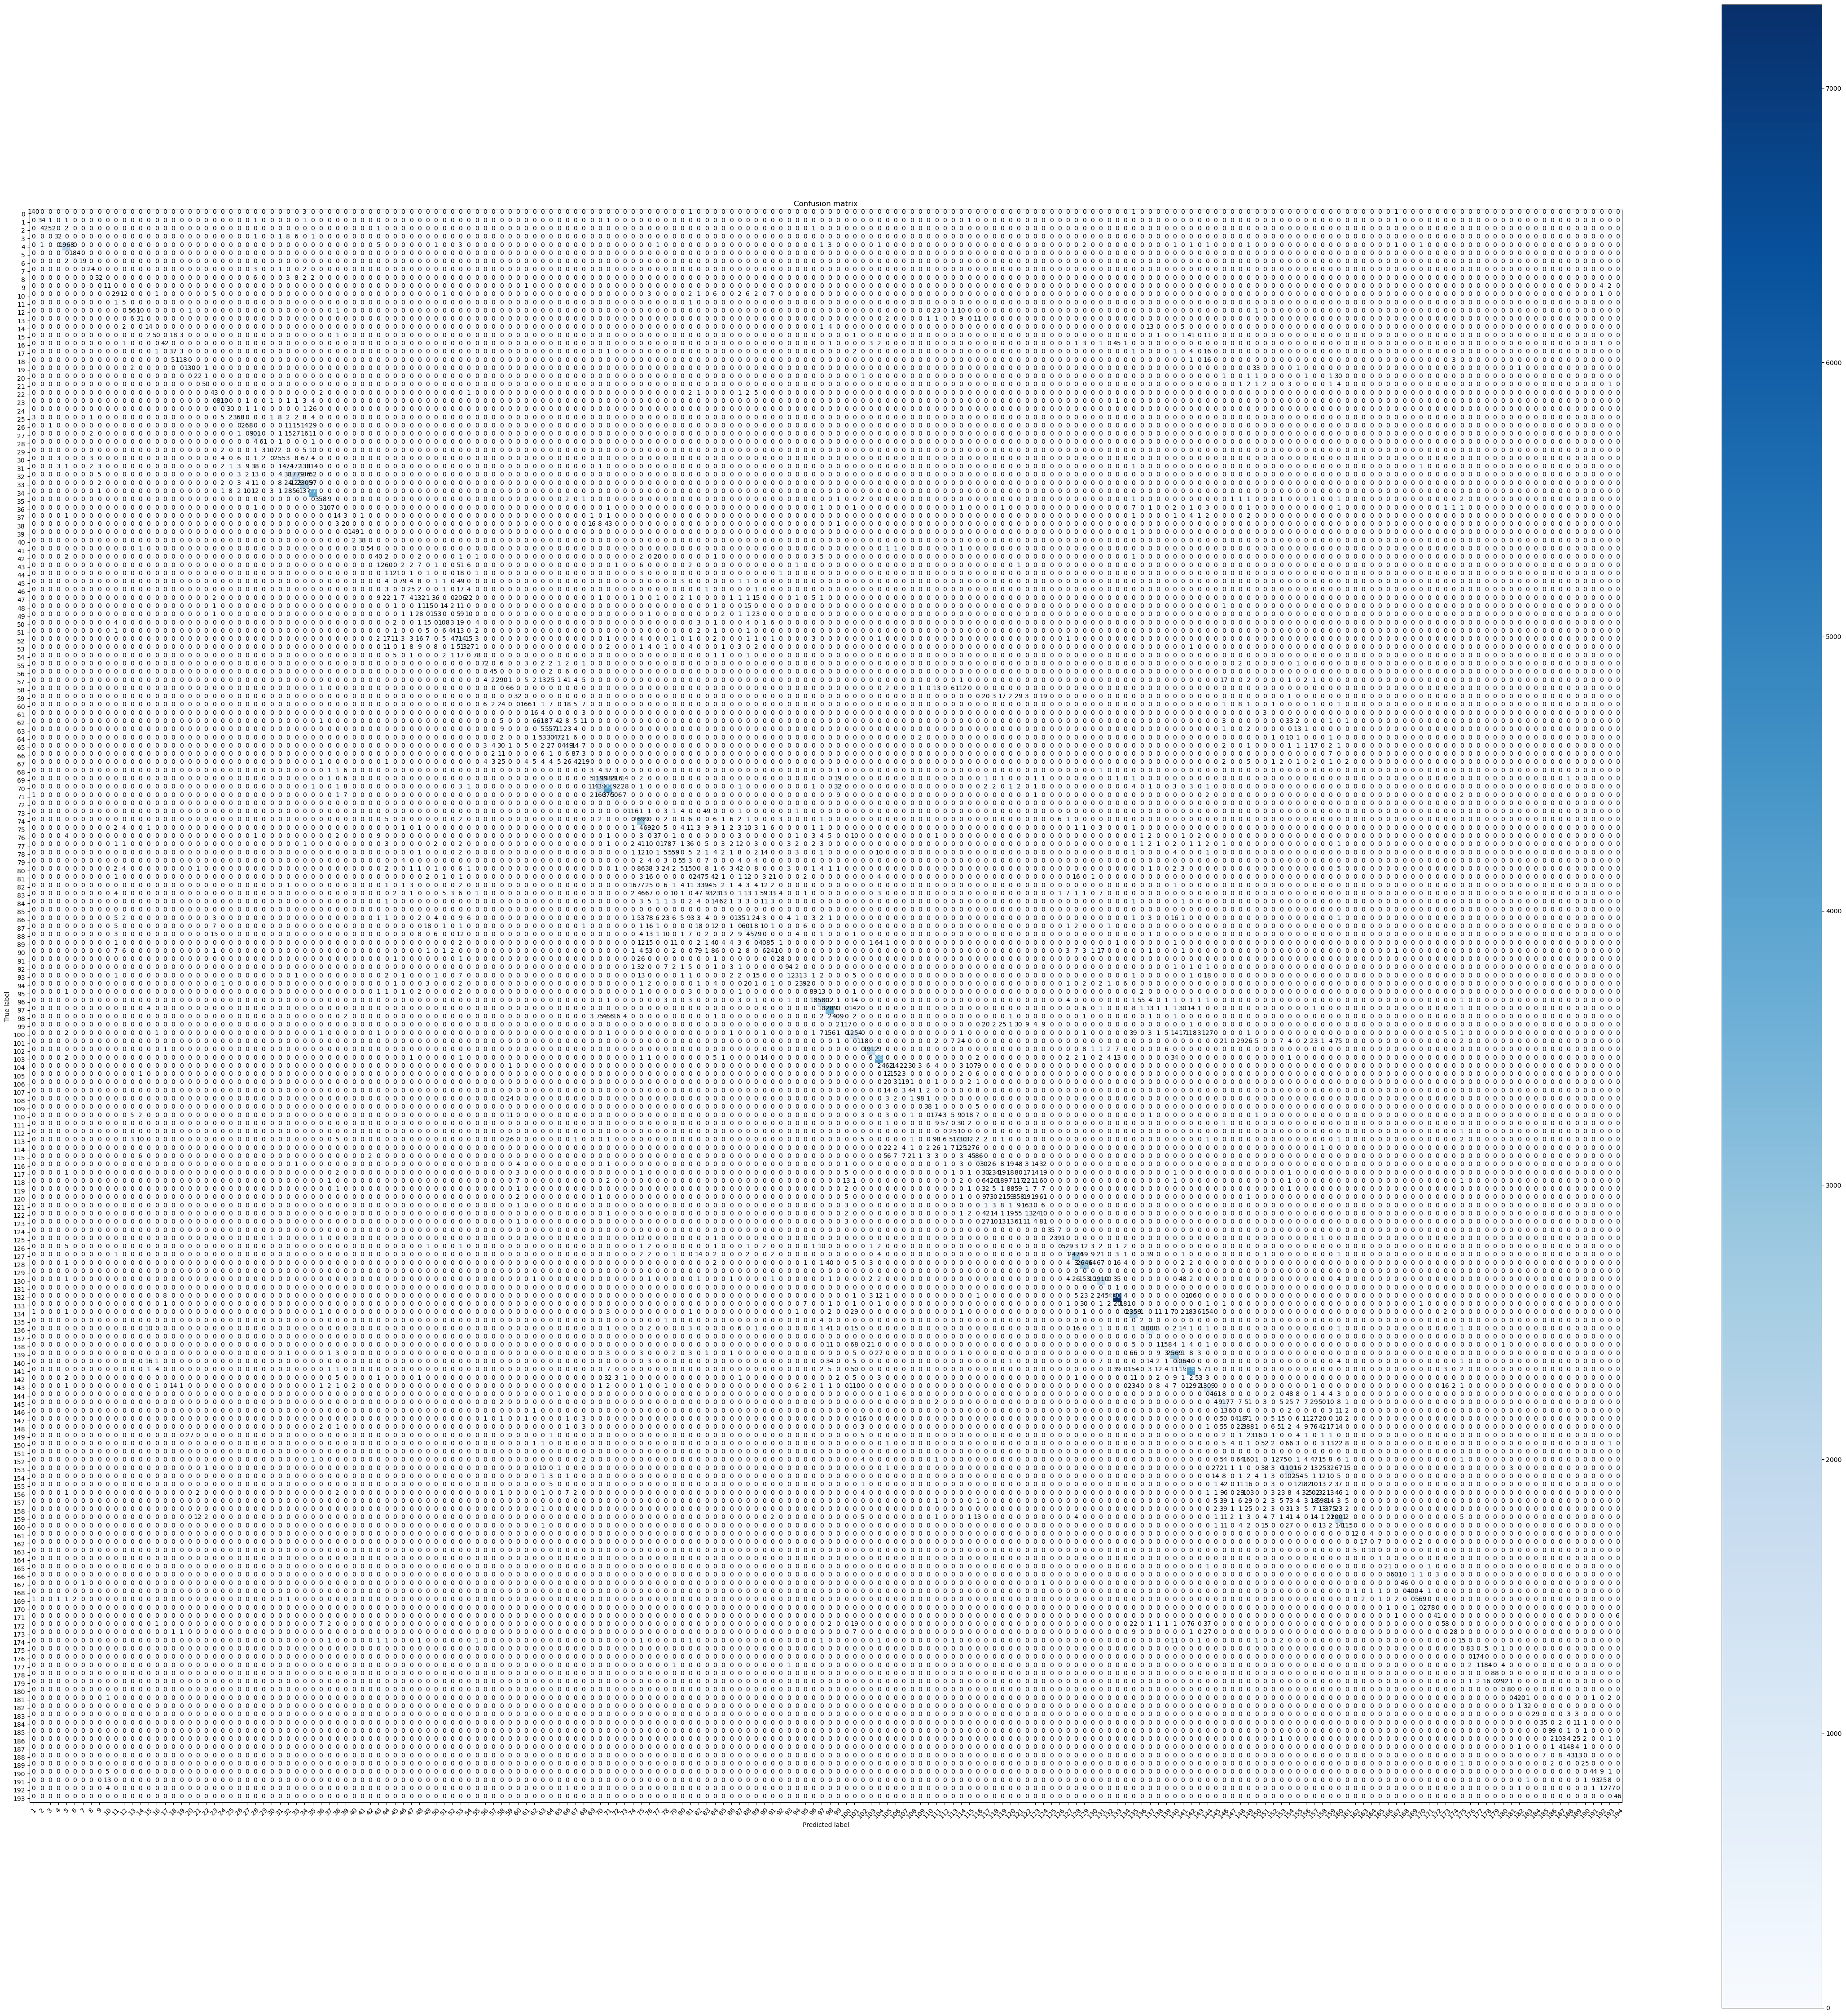

In [30]:
summary.plot_metrics(label_by_class = label_by_class(train_set), figuresize=(45, 45))

In [31]:
report_generator = ml.SampleReportGenerator(
    test_set, 
    summary.targets,
    summary.predictions,
    IMAGES_PATH
)

report = report_generator()

report.to_csv(f'{DATASET_PATH}/bert-model-fail-report.csv', index=False)

Total Fails: 100.00%


Determinamos cuales son las clases con bajo **f1-score**:

In [32]:
gt_f1_score = 0
lt_f1_score = 0.27

classes = summary.predicted_classes_by(
    gt_f1_score = gt_f1_score,
    lt_f1_score = lt_f1_score,
    label_by_class = label_by_class(train_set)
)

report1 = report[(report['pred.class'].isin(classes)) & (report['pred.class'] != report['true.class'])]
report1.to_csv(f'{DATASET_PATH}/f1_score_gt_{gt_f1_score}-lt_{lt_f1_score}-bert-model-fail-report.csv', index=False)
report1.shape, test_set.shape

((62, 14), (113884, 14))

In [33]:
ut.display_html(report1.sample(frac=1).head(5))

,true.text,true.class,true.image,pred.class,pred.image.0,pred.image.1,pred.image.2,pred.image.3,pred.image.4,pred.image.5,pred.image.6,pred.image.7,pred.image.8,pred.image.9
99272,Description: Wilma cropped pearl shrug. Gender: women. Brand: alice + olivia. Materials: Nylon Spandex/Elastane viscose.,clothing~jackets~cropped jackets,,clothing~tops~cardigans,,,,,,,,,,
104253,Description: Larissa floral-print minidress. Gender: women. Brand: rixo. Materials: Cotton.,clothing~dresses~day dresses,,clothing~dresses~beach dresses,,,,,,,,,,
971,Description: button-front sundress. Gender: women. Brand: tory burch. Materials: Cotton.,clothing~dresses~day dresses,,clothing~dresses~beach dresses,,,,,,,,,,
104744,Description: band-collar kaftan maxi dress. Gender: women. Brand: bambah. Materials: Polyester Cotton.,clothing~dresses~day dresses,,clothing~dresses~beach dresses,,,,,,,,,,
19513,Description: Anaal cotton minidress. Gender: women. Brand: anaak. Materials: Cotton.,clothing~dresses~day dresses,,clothing~dresses~beach dresses,,,,,,,,,,


In [34]:
report1 = report[report['pred.class'] == report['true.class']]
report1.to_csv(f'{DATASET_PATH}/f1_score_gt_{gt_f1_score}-lt_{lt_f1_score}-bert-model-fail-report.csv', index=False)
report1.shape, test_set.shape

((92570, 14), (113884, 14))

In [35]:
ut.display_html(report1.sample(frac=1).head(5))

,true.text,true.class,true.image,pred.class,pred.image.0,pred.image.1,pred.image.2,pred.image.3,pred.image.4,pred.image.5,pred.image.6,pred.image.7,pred.image.8,pred.image.9
80604,Description: floral-lace high-neck blouse. Gender: women. Brand: tom ford. Materials: Polyamide Cotton viscose Polyester Silk.,clothing~tops~blouses,,clothing~tops~blouses,,,,,,,,,,
2716,Description: MAHINA tank top. Gender: women. Brand: loulou studio. Materials: Pima Cotton.,clothing~tops~blouses,,clothing~tops~blouses,,,,,,,,,,
99644,Description: straight-leg tailored trousers. Gender: men. Brand: ferrari. Materials: Polyamide Cotton Spandex/Elastane.,clothing~trousers~tailored trousers,,clothing~trousers~tailored trousers,,,,,,,,,,
98785,Description: off-centre fastening tapered trousers. Gender: women. Brand: alessia santi. Materials: Cotton.,clothing~trousers~tapered trousers,,clothing~trousers~tapered trousers,,,,,,,,,,
36962,Description: embroidered-logo long-sleeve sweatshirt. Gender: women. Brand: versace jeans couture. Materials: Cotton.,clothing~tops~sweatshirts,,clothing~tops~sweatshirts,,,,,,,,,,


In [36]:
branch_by_seq = {r['branch_seq']: r['branch'] for _, r in train_set[['branch_seq', 'branch']].drop_duplicates().iterrows()}

branch_predictions = [branch_by_seq[e] for e in np.concatenate(summary.predictions)]
branch_targets     = [branch_by_seq[e] for e in np.concatenate(summary.targets)]

family_predictions = [e.split('~')[0] for e in branch_predictions]
family_targets     = [e.split('~')[0] for e in branch_targets]

category_predictions = [e.split('~')[1] for e in branch_predictions]
category_targets     = [e.split('~')[1] for e in branch_targets]

subcategory_predictions = [e.split('~')[2] for e in branch_predictions]
subcategory_targets     = [e.split('~')[2] for e in branch_targets]

                      precision    recall  f1-score   support

         accessories       0.97      0.98      0.97      2759
          activewear       0.65      0.74      0.69       961
                bags       1.00      1.00      1.00     12997
            clothing       1.00      0.99      0.99     91987
 demi-fine jewellery       0.69      0.78      0.73        37
      fine jewellery       0.82      0.68      0.74        47
           jewellery       0.99      0.99      0.99      1959
lingerie & nightwear       0.30      0.63      0.40       160
           pre-owned       1.00      1.00      1.00       938
               shoes       0.99      0.99      0.99      1987
             watches       1.00      0.88      0.94        52

            accuracy                           0.99    113884
           macro avg       0.85      0.88      0.86    113884
        weighted avg       0.99      0.99      0.99    113884



<Figure size 600x600 with 2 Axes>

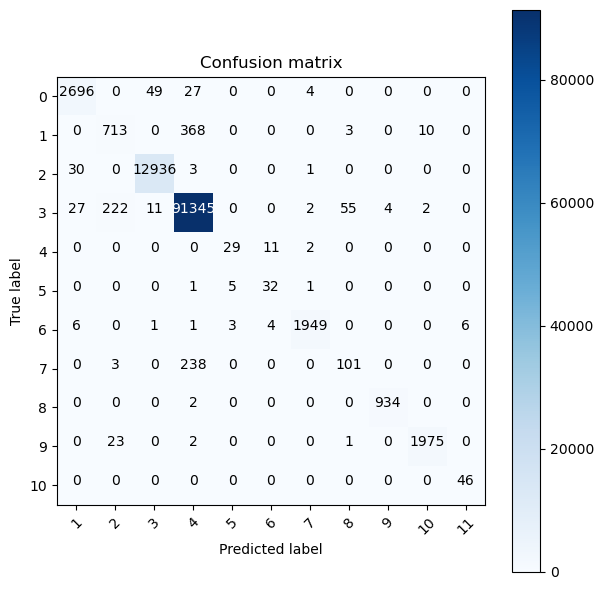

In [37]:
ml.plot_metrics(family_targets, family_predictions, figuresize=(6, 6))

                            precision    recall  f1-score   support

                all in one       0.92      0.94      0.93       505
                 backpacks       0.99      0.98      0.98       827
                beach bags       0.51      0.73      0.60        41
                 beachwear       0.77      0.82      0.79       346
                 belt bags       0.91      0.95      0.93       386
                     belts       0.96      0.96      0.96       146
                    bodies       0.25      0.68      0.37        85
                     boots       0.99      0.99      0.99       424
                 bracelets       0.99      0.99      0.99       608
                      bras       0.38      0.82      0.52        34
           brooches & pins       0.96      1.00      0.98        46
               bucket bags       0.79      0.91      0.85       295
               clutch bags       0.93      0.91      0.92       995
                     coats       0.94      0.94

<Figure size 2000x2000 with 2 Axes>

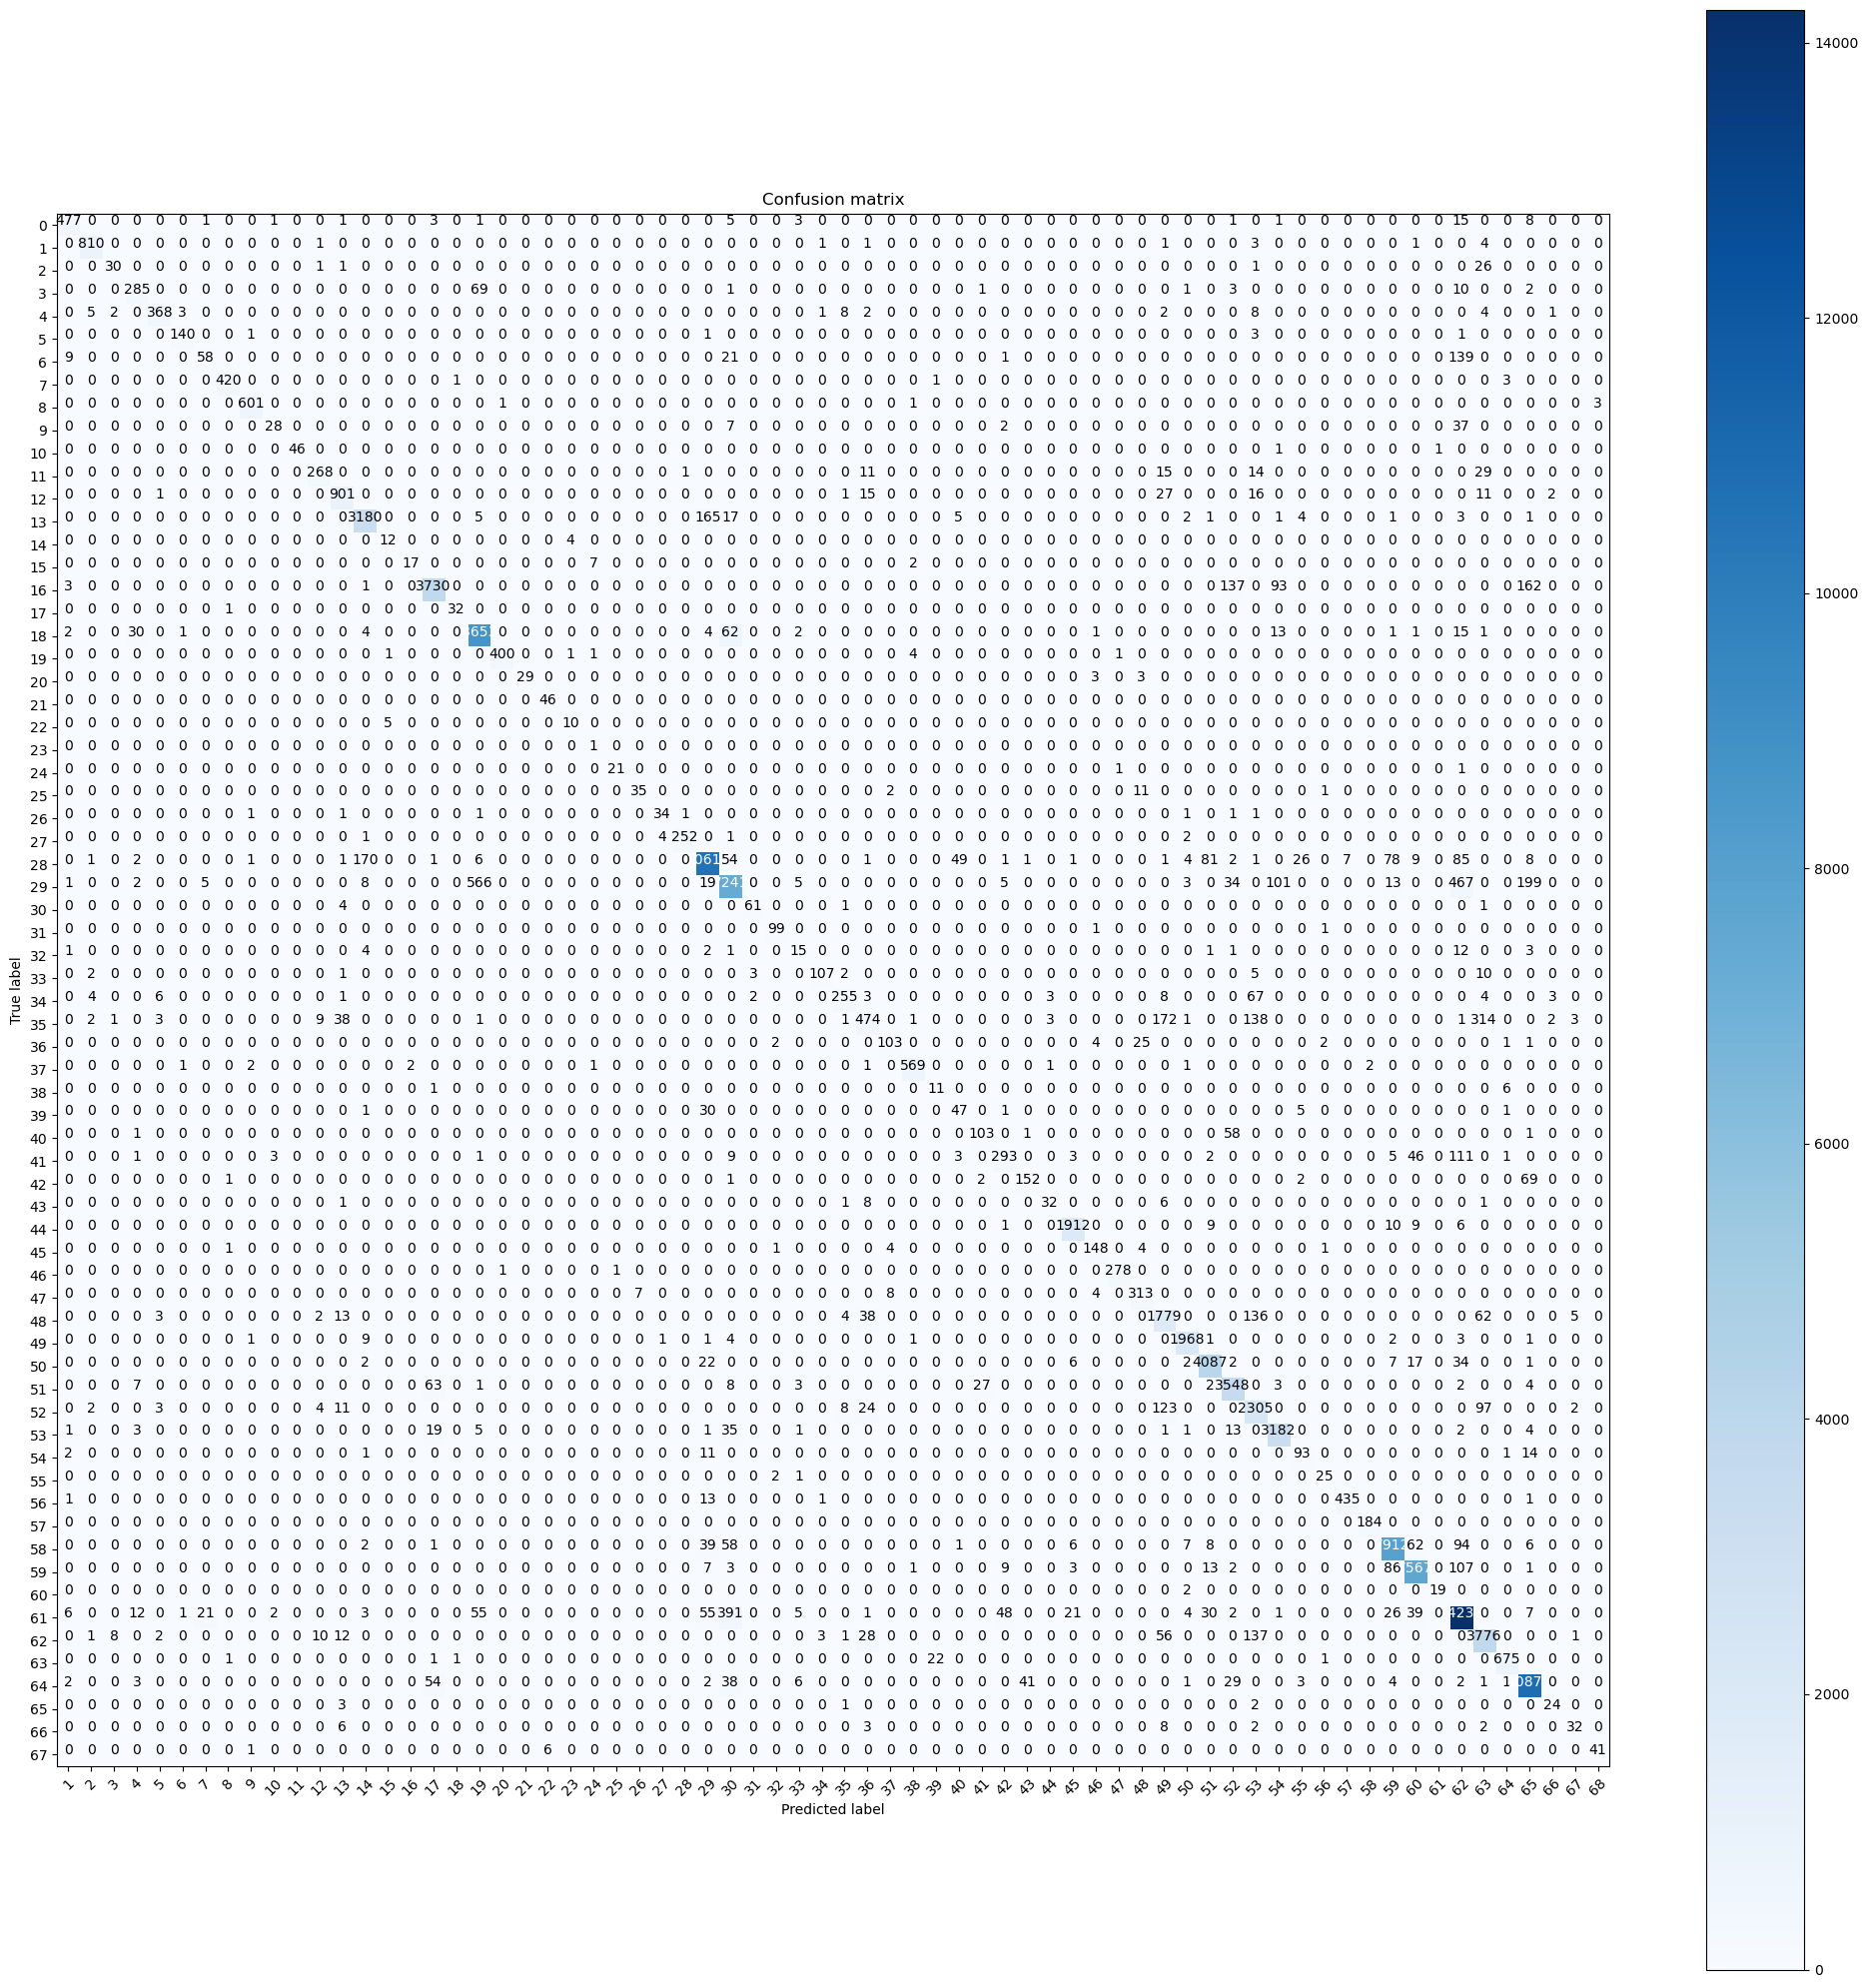

In [38]:
ml.plot_metrics(category_targets, category_predictions, figuresize=(20, 20))

                                   precision    recall  f1-score   support

                    a-line skirts       0.68      0.47      0.56       640
       asymmetric & draped skirts       0.52      0.71      0.60       329
                  beach cover-ups       0.44      0.31      0.36        45
                    beach dresses       0.30      0.48      0.37        93
                   bermuda shorts       0.73      0.76      0.74       606
                    biker jackets       0.66      0.82      0.73       142
                          bikinis       0.99      0.97      0.98       153
                          blazers       0.98      0.85      0.91      3165
                          blouses       0.83      0.80      0.82      2934
                   bomber jackets       0.89      0.65      0.75      1064
                    bootcut jeans       0.78      0.80      0.79        90
                  boyfriend jeans       0.85      0.78      0.81        58
                        

<Figure size 4000x4000 with 2 Axes>

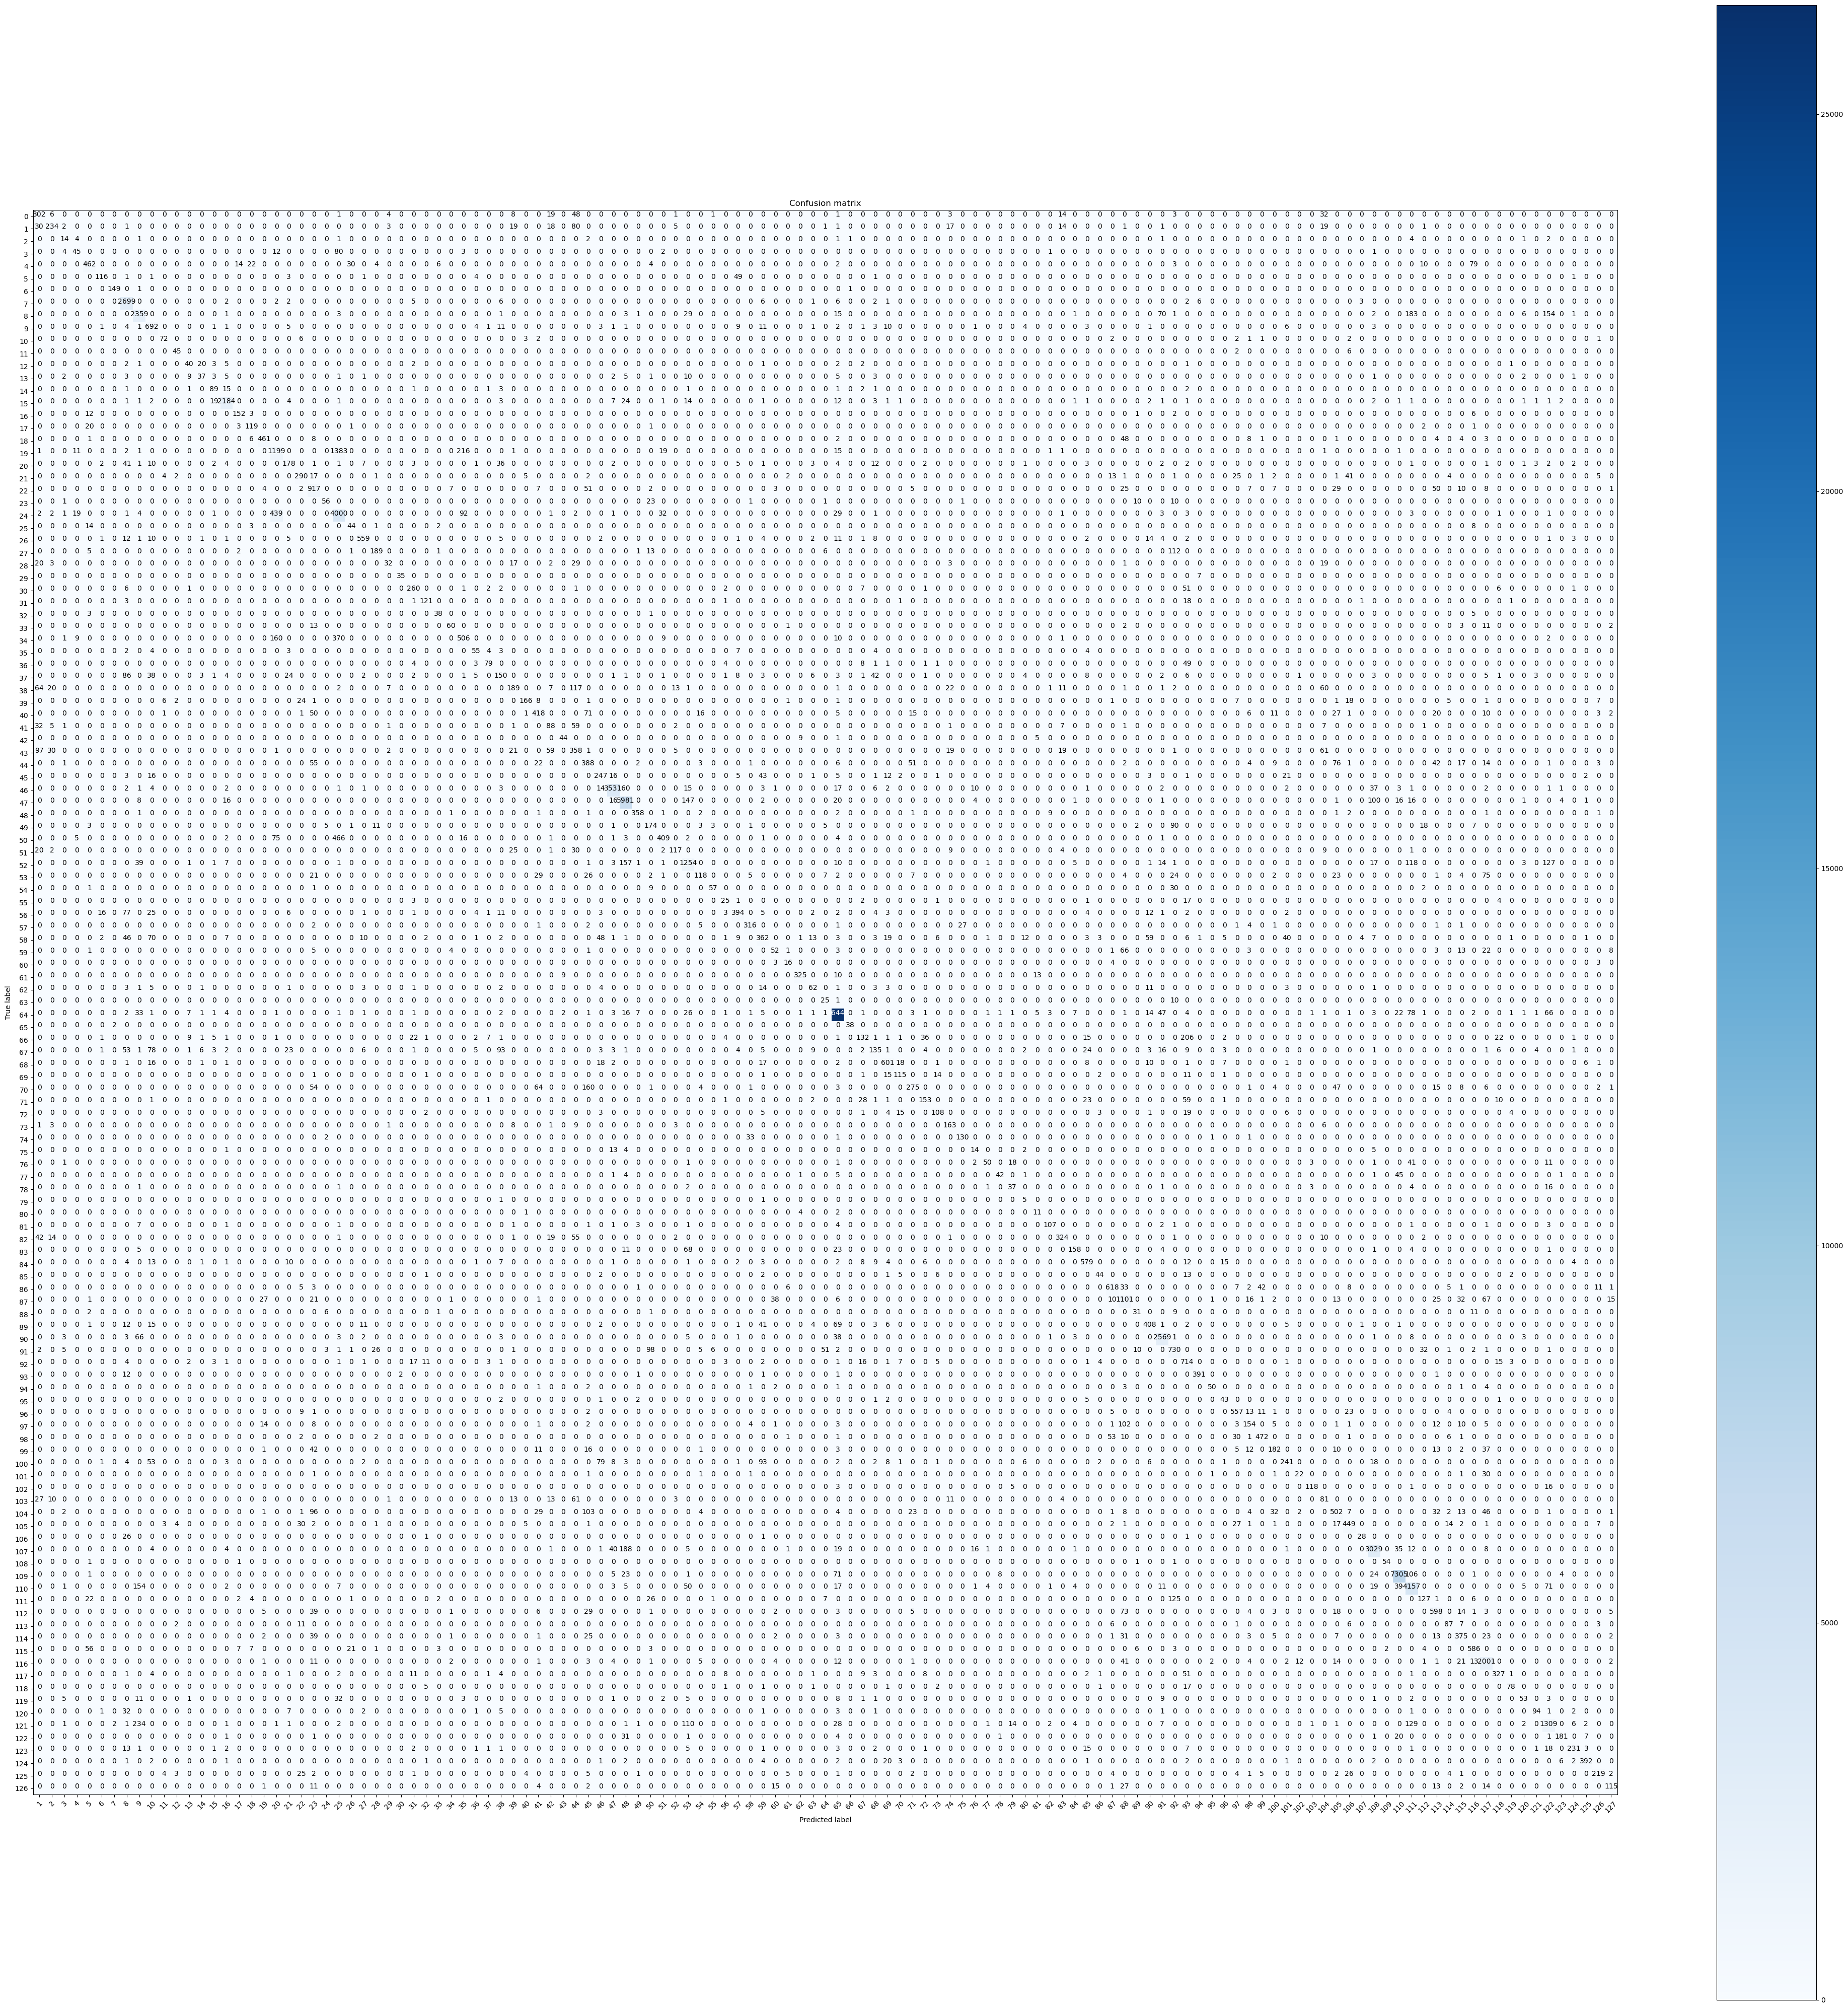

In [39]:
ml.plot_metrics(subcategory_targets, subcategory_predictions, figuresize=(40, 40))